# **Retrieval**
This notebook is where we exploit all the former efforts, including index creation, feature extraction and prediction. We combine these all and apply them to the real dataset and make them practical. In the first step, we unzip the dataset which is the aggregation of the main dataset and the distractor in a single directory in Colab. This is done due to accelerating the total computational time for the process. In this notebook, the dataset is just used to display the results.



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=94d99cbfc6ed7441123784c7855d4c42db535e29996d65cf863905908ab69618
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
# Unzipping dataset
!cp '/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/deployment/food_distr.zip' .
!unzip -q food_distr.zip
!rm food_distr.zip

In [ ]:
!mkdir -p '/content/dataset/query/'
!cp '/content/food_101/375297.jpg' '/content/dataset/query/'

In [ ]:
%cd "/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/notebooks"

/content/gdrive/.shortcut-targets-by-id/1Lqbq3dboVPe48Cxj_XZyhRs54U4hXhEM/[MIRCV]FoodWebSearch/notebooks


In [ ]:
import os
import import_ipynb

import index_creation as index
import numpy as np
import tensorflow as tf
import PIL
from sklearn import preprocessing as sp
from IPython.display import display
from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.keras.preprocessing import dataset_utils

from utils import ids_and_labels_from_file
from utils import preprocess




INDEX_PATH_MN = "/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/deployment/index_mn/index_mn.json"
INDEX_PATH_FT="/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/deployment/index_fine_tuned/index_fine_tuned.json"
QUERY_PATH = "/content/food_101/375297.jpg"
MODEL_PATH = "/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/deployment/food_classifier.h5"
DATA_PATH = '/content/food_101'


BATCH_SIZE = 256
K = 10

In [ ]:
# Retrieve User Query Image
def load_image(path):
  print("Query: ")
  img_disp = PIL.Image.open(path)
  img_disp.thumbnail((224,224))
  display(img_disp)

  image = io_ops.read_file(path)
  image = image_ops.decode_image(image, channels=3, expand_animations=False)
  image = image_ops.resize_images_v2(image, (224,224), method='bilinear')
  image.set_shape((224, 224, 3))
  image=image.numpy()
  image= tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image=np.array([image])
  return image
  
# Extract features
def feature_extractor(model,image):
  features = model.predict(image)
  return features

# Display results
def display_results(results):
  for filename, distance in results:
    print('File: {} - Distance: {:.6f}'.format(filename, distance))
    filepath = os.path.join(DATA_PATH,filename)
    image = PIL.Image.open(filepath)
    image.thumbnail((224,224))
    display(image)

# **VPTree:**
We used a vantage point tree to accelerate the KNN search on the tree to retrieve similar images. We can load the pre-built trees from the disk using the functions deployed in the index_creation notebook. In the event of trees not being available in the disk we can create the trees, by using the functions provided by the same notebook.

In [ ]:
#Creating MobileNet Tree(if necessary)
vp_tree_mn = index.VP_Tree("index_mn",height=10, disk_mode=True, leaves_path='/content/')
vp_tree_mn.create_vptree('/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/deployment/mn_id.npy',
                         '/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/deployment/mn_features.npy')

Number of data: 126000
The max height of the tree is: 15
Tree is building
Building of the tree completed in: 20.298011541366577 s


In [ ]:
#Creating Fine Tuning Tree(if necessary)
vp_tree_ft = index.VP_Tree("index_ft",height=10, disk_mode=True, leaves_path='/content/')
vp_tree_ft.create_vptree('/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/deployment/ft_id.npy',
                         '/content/gdrive/MyDrive/[MIRCV]FoodWebSearch/deployment/ft_features.npy')

Number of data: 126000
The max height of the tree is: 15
Tree is building
Building of the tree completed in: 16.6734402179718 s


In [ ]:
# Load VPTree
vp_tree_mn = index.VP_Tree.load_vptree(INDEX_PATH_MN)
vp_tree_ft = index.VP_Tree.load_vptree(INDEX_PATH_FT)

Tree loaded correctly
Tree loaded correctly


# **Models**
Here, in order to retrieve the images, we load two different models and apply them independently. The first model is pre-trained MobileNet V2, and the second one is the fine-tuned MobileNet that we've achieved in the fine-tuning notebook. In order to extract the features, we use the fine-tuned model cutting the classification layer.

In [ ]:
#Loading Model
food_classifier = tf.keras.models.load_model(MODEL_PATH)
food_classifier = tf.keras.Model(inputs=food_classifier.input, 
                                 outputs=food_classifier.get_layer('dense_hidden').output)
#Loading Mobilnet
mobilenetv2 = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224,224,3),
    pooling='avg')

# **Answering the query:**
In this section as the last part of retrieval, we load one query image as a PIL image. The features of this query image are extracted using MobileNet V2, and fine-tuned model respectively. These features, then are sent to the KNN search based on the corresponding VP-tree model. The KNN search function returns the id and distances (the K closest objects to the query). Then using the zip function we merge these two lists. We have previously become sure that the ids are associated with the correct distance, by setting the shuffle parameter to false in the utils notebook. Finally, the images are displayed with the corresponding id and distance. 

Query: 


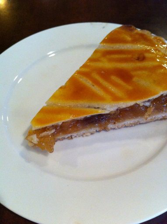

Query answered in 2.932675361633301  s
File: 375297.jpg - Distance: 0.000000


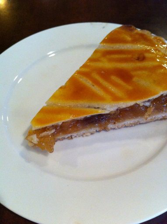

File: 3659123.jpg - Distance: 17.480194


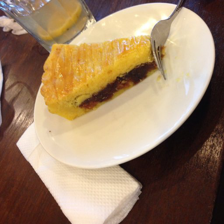

File: 1425392.jpg - Distance: 17.539740


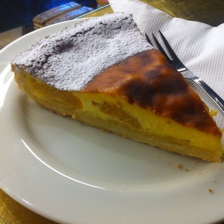

File: 269992.jpg - Distance: 17.681519


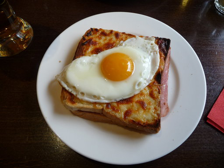

File: 186277.jpg - Distance: 17.682541


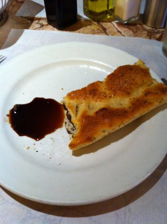

File: 3729671.jpg - Distance: 17.797258


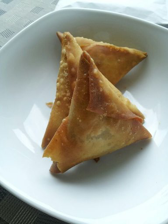

File: 202652.jpg - Distance: 17.797302


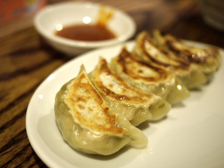

File: 1179302.jpg - Distance: 17.859930


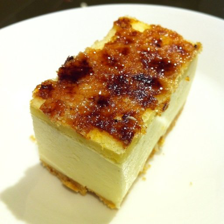

File: 2033012.jpg - Distance: 17.898502


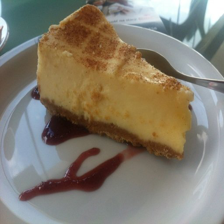

File: 1654085.jpg - Distance: 17.934601


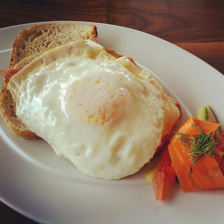

In [ ]:
#Find Results using MOBILENET
query_mn = load_image(QUERY_PATH)
query_f_mn = feature_extractor(mobilenetv2,query_mn)

ids,distances = vp_tree_mn.knn_search(K,query_f_mn)

ids_str = [id[0] for id in ids]
zipped = zip(ids_str,distances)
display_results(zipped)

Query: 


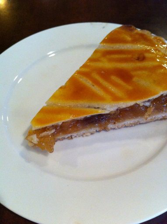

Query answered in 2.119691848754883  s
File: 375297.jpg - Distance: 0.000007


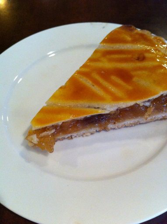

File: 3659123.jpg - Distance: 17.460724


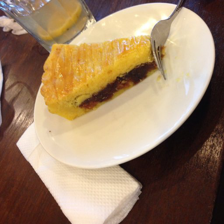

File: 1425392.jpg - Distance: 17.745762


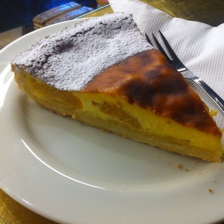

File: 656323.jpg - Distance: 19.311619


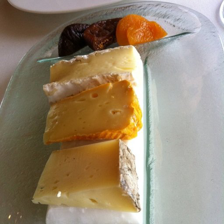

File: 176394.jpg - Distance: 19.342794


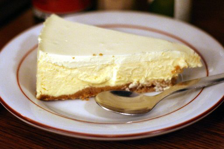

File: 3277458.jpg - Distance: 19.469046


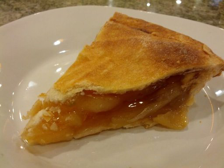

File: 1656986.jpg - Distance: 19.540836


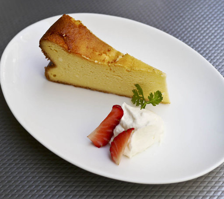

File: 401008.jpg - Distance: 19.826321


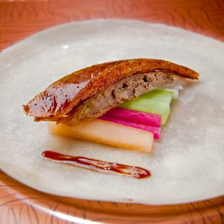

File: 3351812.jpg - Distance: 19.911949


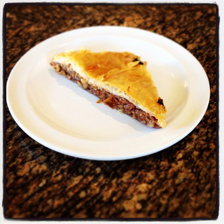

File: 2317205.jpg - Distance: 19.961628


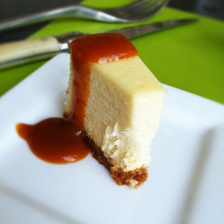

In [ ]:
#Find Results using OUR MODEL

query_image = load_image(QUERY_PATH)
features2 = feature_extractor(food_classifier,query_image)

ids2,distances2 = vp_tree_ft.knn_search(K,features2)
ids_str_2 = [id[0] for id in ids2]
zipped = zip(ids_str_2,distances2)
display_results(zipped)